In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import pickle

This dataset was obtained from kaggle here: https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022 <br>

The following is from the dataset description: <br>
The Bank Account Fraud (BAF) suite of datasets has been published at NeurIPS 2022 and it comprises a total of 6 different synthetic bank account fraud tabular datasets. BAF is a realistic, complete, and robust test bed to evaluate novel and existing methods in ML and fair ML, and the first of its kind!

This suite of datasets is:

Realistic, based on a present-day real-world dataset for fraud detection;
Biased, each dataset has distinct controlled types of bias;
Imbalanced, this setting presents a extremely low prevalence of positive class;
Dynamic, with temporal data and observed distribution shifts;
Privacy preserving, to protect the identity of potential applicants we have applied differential privacy techniques (noise addition), feature encoding and trained a generative model (CTGAN).


There dataset has 5 variants besides the original: <br>
base - sampled to best represent original dataset <br>
- v1 - higher group size disparity than base. <br>
- v2 - higher prevalence disparity than base. <br>
- v3 - better separability for one of the groups. <br>
- v4 - has higher prevalence disparity in train. <br>
- v5 - has better separability in train for one of the groups. <br>

I will use only the base dataset. There are 1 million instances, where only 11000 are positive instances.

In [29]:
df= pd.read_csv("Base.csv")

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
df

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,10650.765523,3134.319630,3863.647740,1,6,CA,185,0,BA,1,0,24,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,534.047319,2670.918292,3124.298166,718,3,CA,259,1,BA,0,0,15,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,4048.534263,2893.621498,3159.590679,1,14,CB,177,1,BA,0,1,-1,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,3457.064063,4054.908412,3022.261812,1921,6,CA,110,1,BA,0,1,31,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,5020.341679,2728.237159,3087.670952,1990,2,CA,295,1,BA,1,0,31,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.6,0.192631,-1,104,40,0.030592,-1.044454,AB,804,7905.711839,8341.468557,4972.635997,1,8,CA,75,1,BC,1,1,25,0,200.0,0,INTERNET,8.511502,linux,1,1,0,4
999996,0,0.8,0.322989,148,9,50,1.628119,-1.409803,AC,3306,5391.470463,4955.170808,5022.728108,0,2,CC,154,1,BC,1,1,-1,0,200.0,0,INTERNET,8.967865,windows,0,1,0,4
999997,0,0.8,0.879403,-1,30,20,0.018563,34.692760,AA,1522,8063.102636,5670.654316,4377.196321,2023,6,CF,64,0,BC,0,1,11,0,200.0,0,INTERNET,8.195531,other,0,1,0,4
999998,0,0.9,0.762112,-1,189,20,0.015352,94.661055,AA,1418,8092.641762,3982.582204,4394.803296,1678,6,CA,163,0,BA,1,0,28,0,500.0,0,INTERNET,4.336064,windows,1,1,0,4


In [10]:
df['fraud_bool'].value_counts()

0    988971
1     11029
Name: fraud_bool, dtype: int64

In [11]:
df['fraud_bool'].value_counts()/df.shape[0]*100 #same class distribution for all 5 variations of datasets

0    98.8971
1     1.1029
Name: fraud_bool, dtype: float64

In [30]:
df.drop('device_fraud_count',axis=1,inplace=True)

In [13]:
df

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,10650.765523,3134.319630,3863.647740,1,6,CA,185,0,BA,1,0,24,0,500.0,0,INTERNET,3.888115,windows,0,1,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,534.047319,2670.918292,3124.298166,718,3,CA,259,1,BA,0,0,15,0,1500.0,0,INTERNET,31.798819,windows,0,1,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,4048.534263,2893.621498,3159.590679,1,14,CB,177,1,BA,0,1,-1,0,200.0,0,INTERNET,4.728705,other,0,1,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,3457.064063,4054.908412,3022.261812,1921,6,CA,110,1,BA,0,1,31,1,200.0,0,INTERNET,2.047904,linux,0,1,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,5020.341679,2728.237159,3087.670952,1990,2,CA,295,1,BA,1,0,31,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.6,0.192631,-1,104,40,0.030592,-1.044454,AB,804,7905.711839,8341.468557,4972.635997,1,8,CA,75,1,BC,1,1,25,0,200.0,0,INTERNET,8.511502,linux,1,1,4
999996,0,0.8,0.322989,148,9,50,1.628119,-1.409803,AC,3306,5391.470463,4955.170808,5022.728108,0,2,CC,154,1,BC,1,1,-1,0,200.0,0,INTERNET,8.967865,windows,0,1,4
999997,0,0.8,0.879403,-1,30,20,0.018563,34.692760,AA,1522,8063.102636,5670.654316,4377.196321,2023,6,CF,64,0,BC,0,1,11,0,200.0,0,INTERNET,8.195531,other,0,1,4
999998,0,0.9,0.762112,-1,189,20,0.015352,94.661055,AA,1418,8092.641762,3982.582204,4394.803296,1678,6,CA,163,0,BA,1,0,28,0,500.0,0,INTERNET,4.336064,windows,1,1,4


In [31]:
num_cat = ['email_is_free','phone_home_valid','phone_mobile_valid','has_other_cards','foreign_request','keep_alive_session']

num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('fraud_bool')
num_cols = list(set(num_cols)-set(num_cat))

cat_cols = df.select_dtypes(include='O').columns.tolist()
cat_cols = cat_cols + num_cat

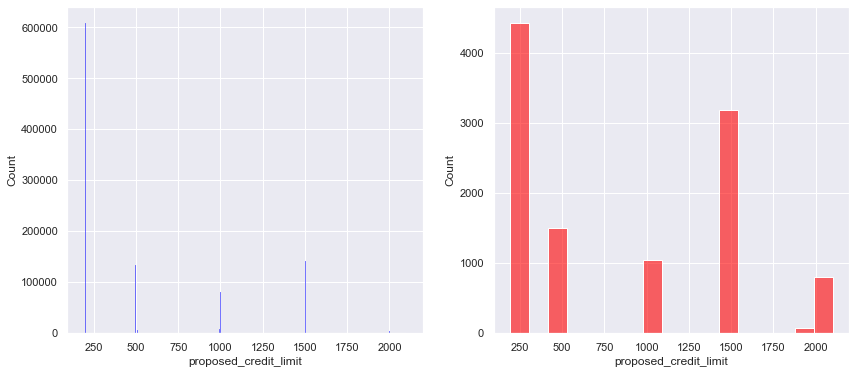

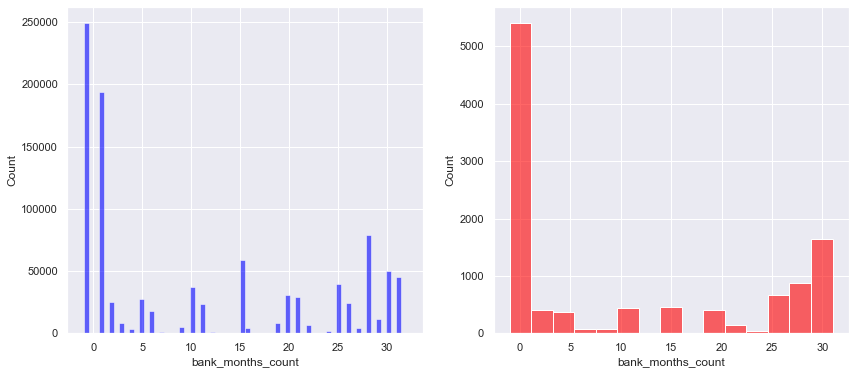

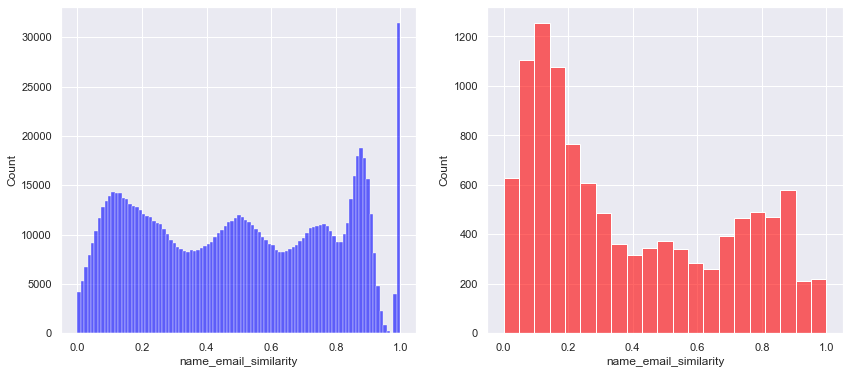

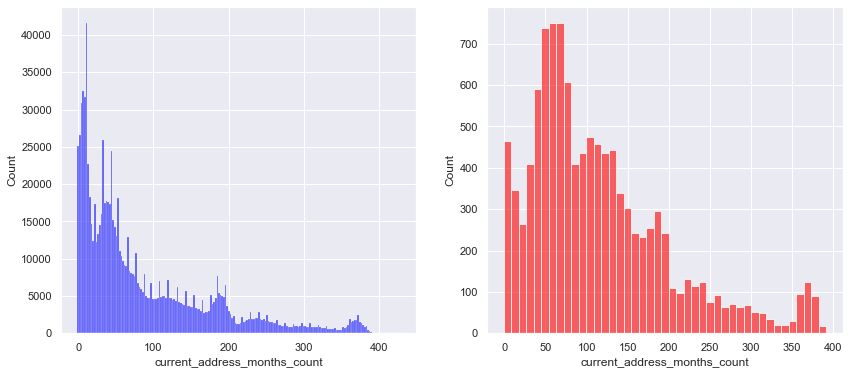

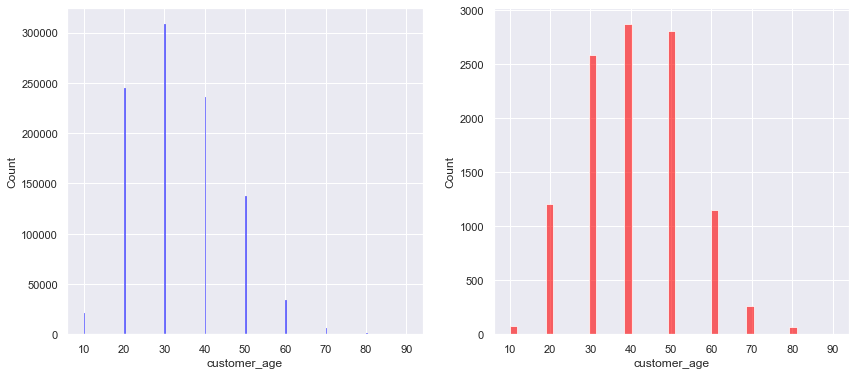

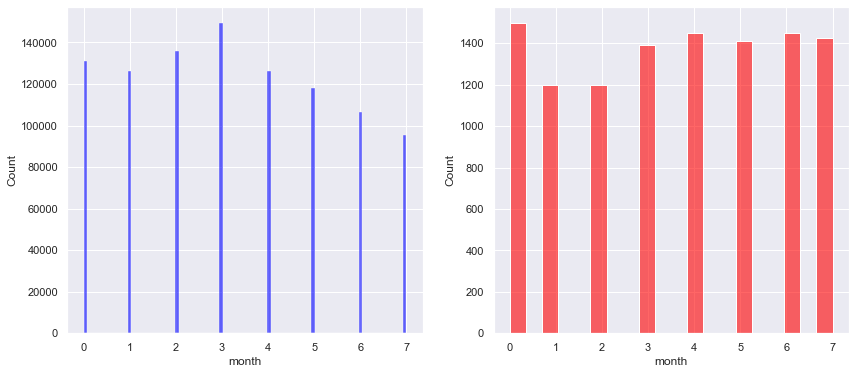

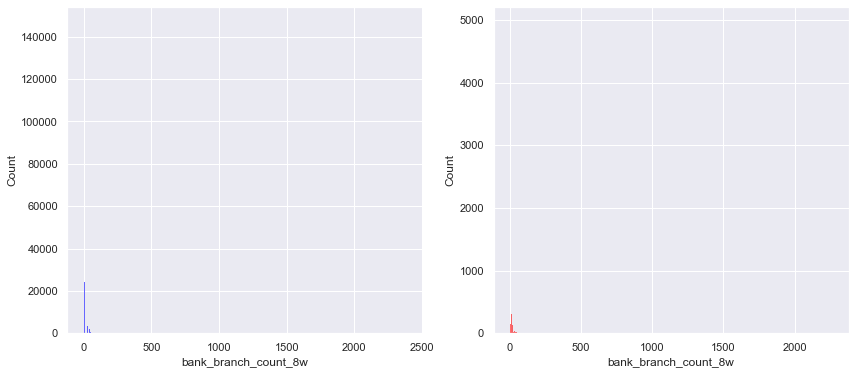

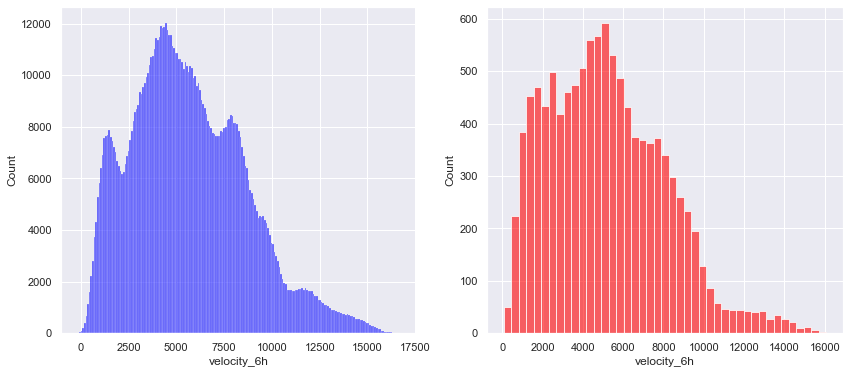

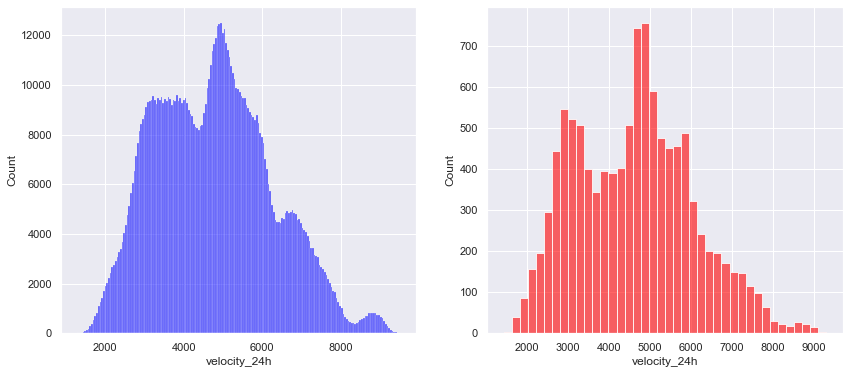


KeyboardInterrupt



In [83]:
for i in num_cols:
    fig,ax = plt.subplots(1,2,figsize=(14,6))
    sns.histplot(data=df.loc[df['fraud_bool']==0],x=i,alpha=0.6,color='blue',ax=ax[0])
    sns.histplot(data=df.loc[df['fraud_bool']==1],x=i,alpha=0.6,color='red',ax=ax[1])
    plt.show()

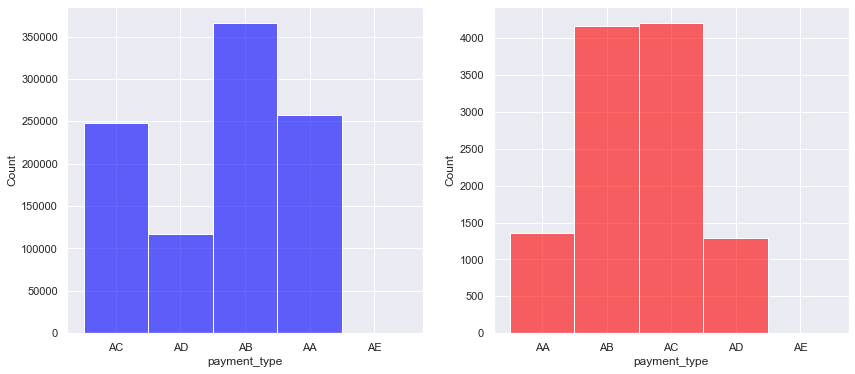

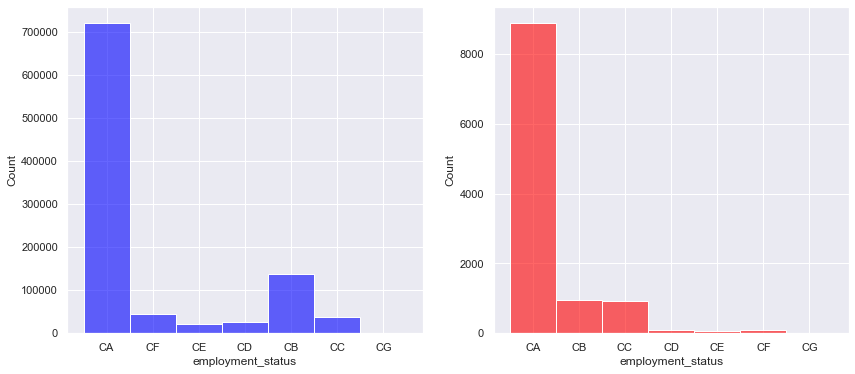

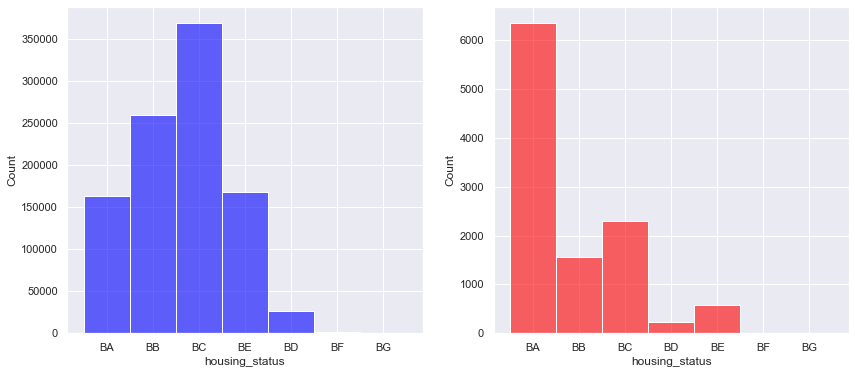

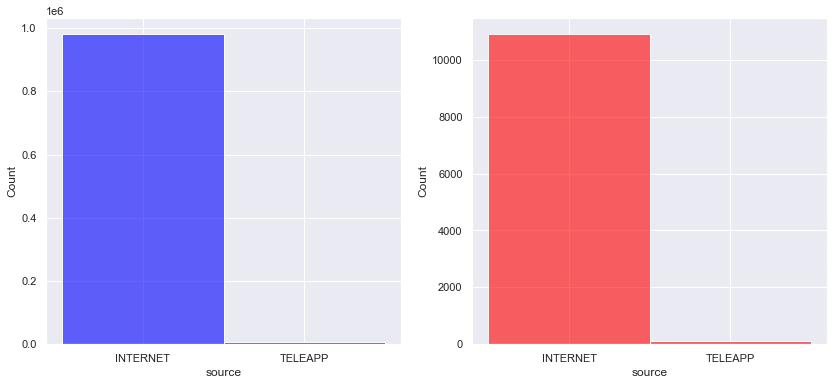

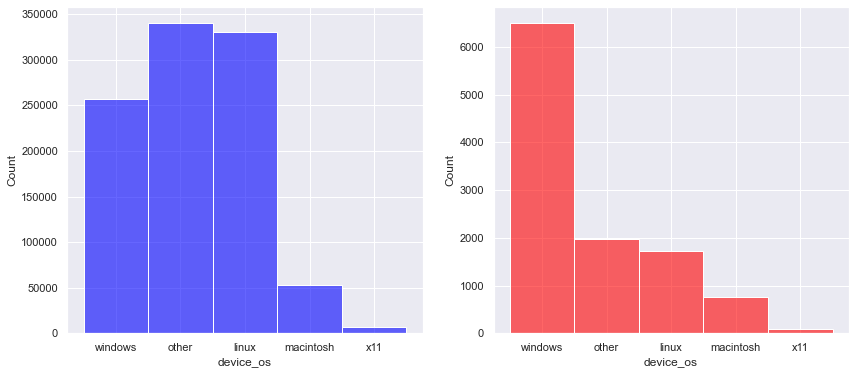

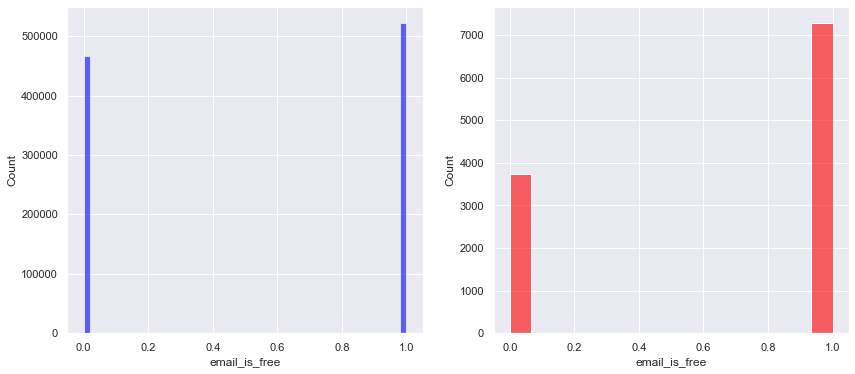

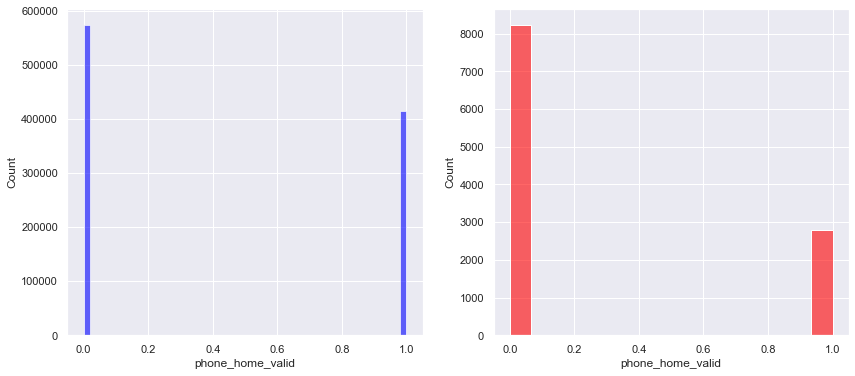

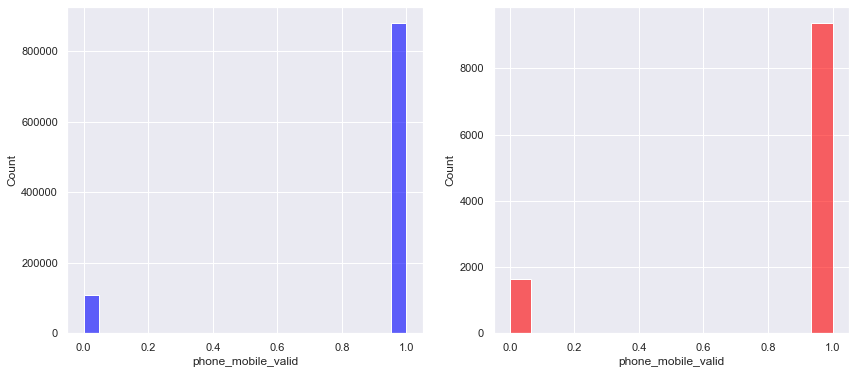

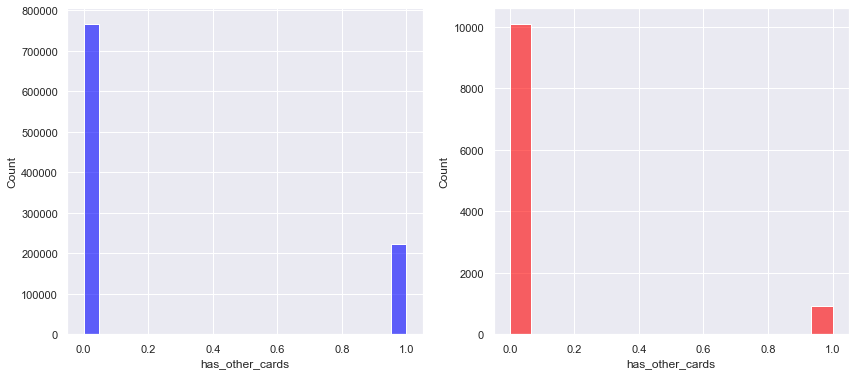

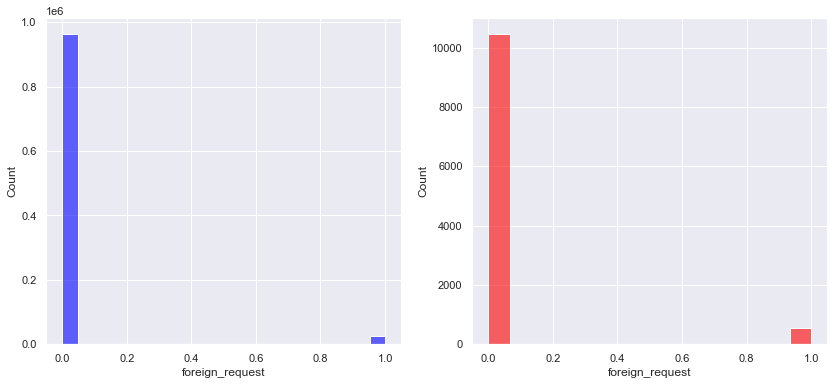

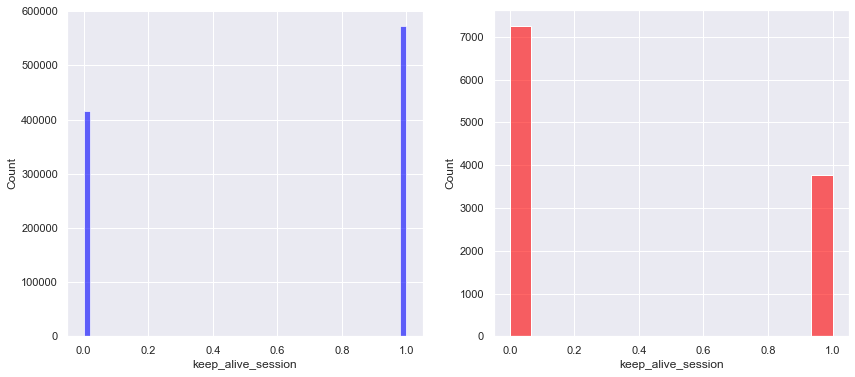

In [84]:
for i in cat_cols:
    fig,ax = plt.subplots(1,2,figsize=(14,6))
    sns.histplot(data=df.loc[df['fraud_bool']==0],x=i,alpha=0.6,color='blue',ax=ax[0])
    sns.histplot(data=df.loc[df['fraud_bool']==1],x=i,alpha=0.6,color='red',ax=ax[1])
    plt.show()

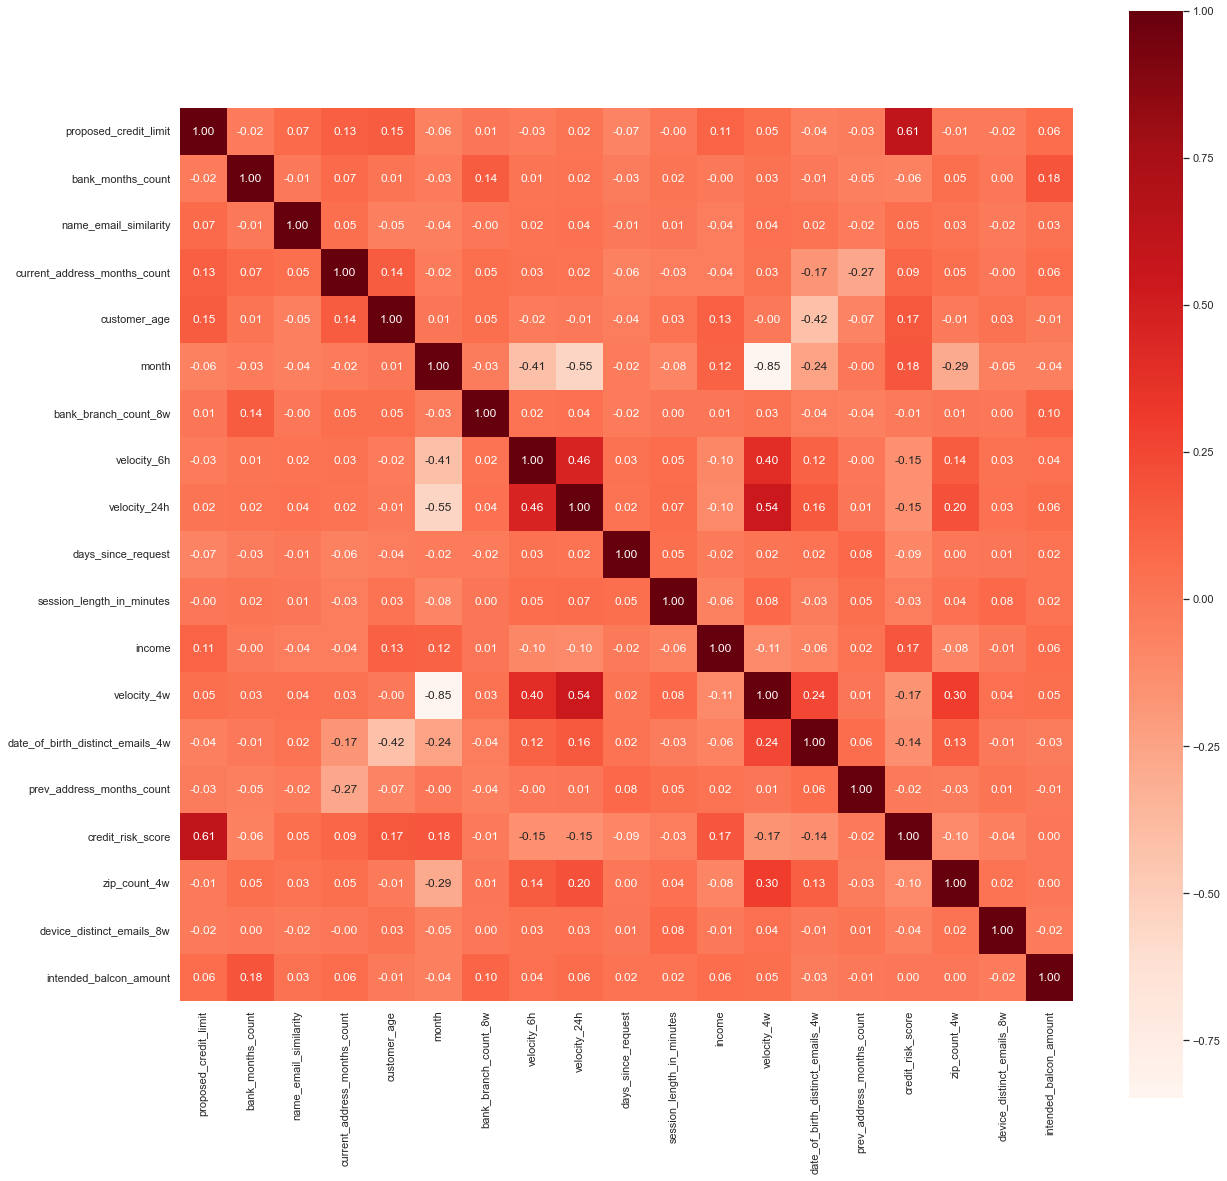

In [85]:
fig,ax = plt.subplots(figsize=(20,20))
sns.heatmap(df[num_cols].corr(),square=True,annot=True,cbar=True,cmap='Reds',fmt=".2f",ax=ax)
plt.show()

### Resampling

I will under-sample the majority class to match the number of minority class samples

In [32]:
n0, n1 = df['fraud_bool'].value_counts() #number of instances in each class

class0 = df[df['fraud_bool']==0]
class1 = df[df['fraud_bool']==1]

In [33]:
print("Before Resampling")
print("Percentage of Class 0: {:.2f}%".format(n0/(n0+n1)*100)) 
print("Percentage of Class 1: {:.2f}%".format(n1/(n0+n1)*100))

class0under = class0.sample(n1,replace=False)
underdf = pd.concat([class0under,class1],axis=0).sample(frac=1)

print("After Resampling")
print("Fraction of Class 0: {:.2f}%".format(underdf['fraud_bool'].value_counts()[0]/underdf.shape[0]*100))
print("Fraction of Class 1: {:.2f}%".format(underdf['fraud_bool'].value_counts()[1]/underdf.shape[0]*100))

Before Resampling
Percentage of Class 0: 98.90%
Percentage of Class 1: 1.10%
After Resampling
Fraction of Class 0: 50.00%
Fraction of Class 1: 50.00%


### Model Fitting

In [34]:
X_train, X_test, y_train, y_test = train_test_split(underdf.drop(['fraud_bool'],axis=1),underdf['fraud_bool'],
                                                    test_size=0.2,random_state=2)

In [35]:
cat = CatBoostClassifier(verbose=False)
cat.fit(X_train, y_train,cat_features=cat_cols)

In [36]:
y_pred_test = cat.predict(X_test)
y_pred_train = cat.predict(X_train)

y_pred_proba_test = cat.predict_proba(X_test)[:,1].reshape(-1,1)
y_pred_proba_train = cat.predict_proba(X_train)[:,1].reshape(-1,1)

In [37]:
y_pred = cat.predict(df.drop(['fraud_bool'],axis=1))
y_pred_proba = cat.predict_proba(df.drop(['fraud_bool'],axis=1))[:,1].reshape(-1,1)
#prediction on Whole dataset - so it includes the instances of negative class which were dropped

In [21]:
print("Classification Reports")
print("Test Set")
print(classification_report(y_test,y_pred_test))

print("Train Set")
print(classification_report(y_train,y_pred_train))

print("Whole  dataset")
print(classification_report(df['fraud_bool'],y_pred))

Classification Reports
Test Set
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      2226
           1       0.82      0.82      0.82      2186

    accuracy                           0.82      4412
   macro avg       0.82      0.82      0.82      4412
weighted avg       0.82      0.82      0.82      4412

Train Set
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      8803
           1       0.88      0.88      0.88      8843

    accuracy                           0.88     17646
   macro avg       0.88      0.88      0.88     17646
weighted avg       0.88      0.88      0.88     17646

Whole  dataset
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    988971
           1       0.05      0.87      0.10     11029

    accuracy                           0.82   1000000
   macro avg       0.52      0.84      0.50   1000000
weighted avg     

In [38]:
print("ROC-AUC Scores")
print("\nTest Set")
print(roc_auc_score(y_test,y_pred_proba_test))

print("\nTrain Set")
print(roc_auc_score(y_train,y_pred_proba_train))

print("\nWhole  dataset")
print(roc_auc_score(df['fraud_bool'],y_pred_proba))

ROC-AUC Scores

Test Set
0.8962155005844326

Train Set
0.9541314402201935

Whole  dataset
0.9212156713733697


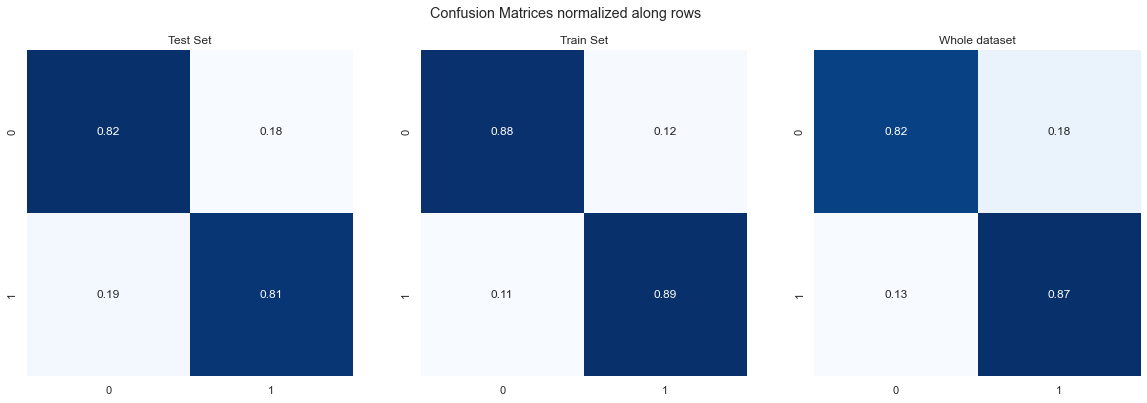

In [39]:
fig,ax = plt.subplots(1,3,figsize=(20,6))
plt.suptitle("Confusion Matrices normalized along rows")
sns.heatmap(confusion_matrix(y_test,y_pred_test,normalize='true'),annot=True,cbar=False,square=True,cmap='Blues',ax=ax[0])
ax[0].set_title("Test Set")

sns.heatmap(confusion_matrix(y_train,y_pred_train,normalize='true'),annot=True,cbar=False,square=True,cmap='Blues',ax=ax[1])
ax[1].set_title("Train Set")

sns.heatmap(confusion_matrix(df['fraud_bool'],y_pred,normalize='true'),annot=True,cbar=False,square=True,cmap='Blues',ax=ax[2])
ax[2].set_title("Whole dataset")
plt.show()

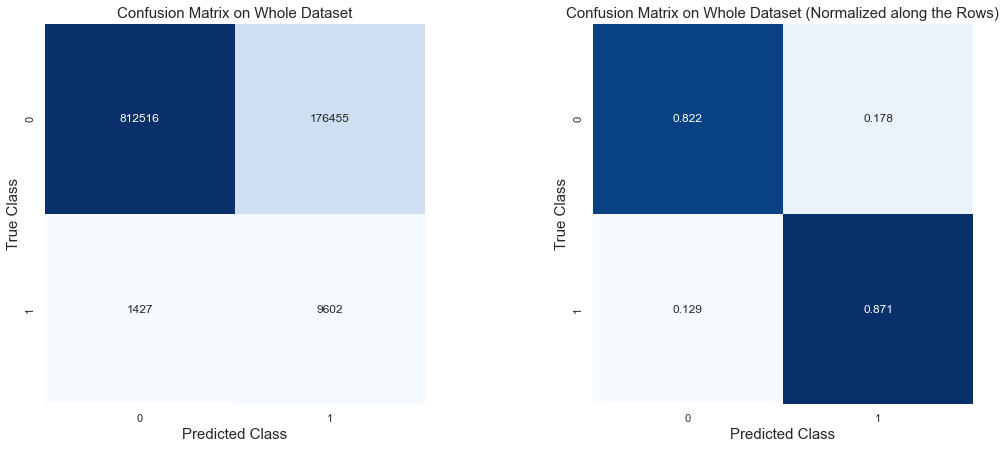

In [40]:
fig,ax = plt.subplots(1,2,figsize=(18,7))
sns.heatmap(confusion_matrix(df['fraud_bool'],y_pred),annot=True,cbar=False,square=True,cmap='Blues',fmt='g',ax=ax[0])
ax[0].set_title("Confusion Matrix on Whole Dataset",fontsize=15)
ax[0].set_xlabel("Predicted Class",fontsize=15)
ax[0].set_ylabel("True Class",fontsize=15)

sns.heatmap(confusion_matrix(df['fraud_bool'],y_pred,normalize='true'),annot=True,cbar=False,square=True,cmap='Blues',fmt='.3f',ax=ax[1])
ax[1].set_title("Confusion Matrix on Whole Dataset (Normalized along the Rows)",fontsize=15)
ax[1].set_xlabel("Predicted Class",fontsize=15)
ax[1].set_ylabel("True Class",fontsize=15)
plt.show()

Not bad, honestly. Given this is OOB, I could totally just run with this.

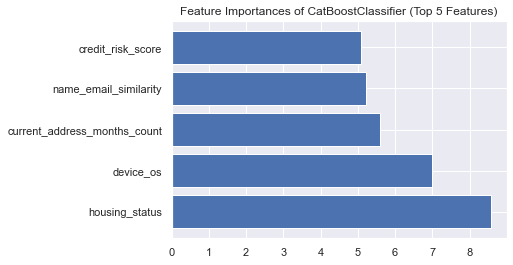

In [24]:
feat_imp_sorted_str = np.flip(np.sort(cat.feature_importances_))[:5]
feat_imp_sorted_args_str = np.flip(np.argsort(cat.feature_importances_))[:5]
feat_names_sorted_str = X_train.columns[feat_imp_sorted_args_str]

plt.barh(feat_names_sorted_str,feat_imp_sorted_str)
plt.title("Feature Importances of CatBoostClassifier (Top 5 Features)")
plt.show()

In [25]:
pickle.dump(cat,open('catboost_bank_account_fraud.pkl','wb'))